## Init

In [ ]:
!nvidia-smi

Tue Dec 28 04:47:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'
!unzip /content/drive/MyDrive/Kaggle/sartorius-cell/sartorius-cell-instance-segmentation.zip

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-l2lwksh3
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-l2lwksh3
     |████████████████████████████████| 49 kB 5.7 MB/s 
     |████████████████████████████████| 74 kB 3.7 MB/s 
     |████████████████████████████████| 145 kB 55.0 MB/s 
     |████████████████████████████████| 130 kB 49.9 MB/s 
     |████████████████████████████████| 749 kB 55.3 MB/s 
     |████████████████████████████████| 843 kB 50.0 MB/s 
     |████████████████████████████████| 596 kB 52.2 MB/s 
     |████████████████████████████████| 112 kB 58.4 MB/s 
  Created wheel for detectron2: filename=detectron2-0.6-cp37-cp37m-linux_x86_64.whl size=5704079 sha256=a60f46f7d46ade01f3d263a549de00da369ceb5e680171158d79134b8fbb1efe
  Stored in directory: /tmp/pip-ephem-wheel-cache-0z3zq5f8/wheels/07/dc/32/0322cb484dbefab8b9366bfedbaff5060ac7d149d69c27ca5d
  Created wheel for fvcore: filename=fvcore

unzip:  cannot find or open /content/drive/MyDrive/Kaggle/sartorius-cell/sartorius-cell-instance-segmentation.zip, /content/drive/MyDrive/Kaggle/sartorius-cell/sartorius-cell-instance-segmentation.zip.zip or /content/drive/MyDrive/Kaggle/sartorius-cell/sartorius-cell-instance-segmentation.zip.ZIP.


In [ ]:
import detectron2
from pathlib import Path
import random, cv2, os
import matplotlib.pyplot as plt
import numpy as np
import pycocotools.mask as mask_util
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger
from detectron2.evaluation.evaluator import DatasetEvaluator
from detectron2.structures import polygons_to_bitmask
from detectron2.evaluation import inference_on_dataset, print_csv_format
from detectron2.utils import comm
from detectron2.engine import BestCheckpointer
from detectron2.checkpoint import DetectionCheckpointer
setup_logger()


<Logger detectron2 (DEBUG)>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Base with all livecell (cascade_mask_rcnn, mask_rcnn_x101 done)

In [ ]:
!kaggle datasets download -d markunys/livecell-dataset

100% 4.50G/4.51G [00:36<00:00, 51.1MB/s]
100% 4.51G/4.51G [00:36<00:00, 133MB/s] 


In [ ]:
!unzip livecell-dataset.zip

In [ ]:
dataDir=Path('/content/LIVECell_dataset_2021/images')
cfg = get_cfg()
register_coco_instances('sartorius_train',{}, '/content/livecell_annotations_train.json', dataDir)
register_coco_instances('sartorius_val',{},'/content/livecell_annotations_val.json', dataDir)
register_coco_instances('sartorius_test',{}, '/content/livecell_annotations_test.json', dataDir)
metadata = MetadataCatalog.get('sartorius_train')
train_ds = DatasetCatalog.get('sartorius_train')

[12/15 11:31:50 d2.data.datasets.coco]: Loading /content/livecell_annotations_train.json takes 21.46 seconds.
WARNING [12/15 11:31:50 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/15 11:31:50 d2.data.datasets.coco]: Loaded 3253 images in COCO format from /content/livecell_annotations_train.json


In [ ]:
def polygon_to_rle(polygon, shape=(520, 704)):
    #print(polygon)
    mask = polygons_to_bitmask([np.asarray(polygon) + 0.25], shape[0], shape[1])
    rle = mask_util.encode(np.asfortranarray(mask))
    return rle

# Taken from https://www.kaggle.com/theoviel/competition-metric-map-iou
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    return np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)

def score(pred, targ):
    pred_masks = pred['instances'].pred_masks.cpu().numpy()
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    enc_targs = list(map(lambda x:x['segmentation'], targ))
    enc_targs = [polygon_to_rle(enc_targ[0]) for enc_targ in enc_targs]
    ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, ious)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)

class MAPIOUEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name):
        dataset_dicts = DatasetCatalog.get(dataset_name)
        self.annotations_cache = {item['image_id']:item['annotations'] for item in dataset_dicts}
            
    def reset(self):
        self.scores = []

    def process(self, inputs, outputs):
        for inp, out in zip(inputs, outputs):
            if len(out['instances']) == 0:
                self.scores.append(0)    
            else:
                targ = self.annotations_cache[inp['image_id']]
                self.scores.append(score(out, targ))

    def evaluate(self):
        return {"MaP IoU": np.mean(self.scores)}

class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)

    def build_hooks(self):

        # copy of cfg
        cfg = self.cfg.clone()

        # build the original model hooks
        hooks = super().build_hooks()

        # add the best checkpointer hook
        hooks.insert(-1, BestCheckpointer(cfg.TEST.EVAL_PERIOD, 
                                         DetectionCheckpointer(self.model, cfg.OUTPUT_DIR),
                                         "MaP IoU",
                                         "max",
                                         ))
        return hooks


In [ ]:
cfg.merge_from_file(model_zoo.get_config_file("Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("sartorius_train", "sartorius_test")
cfg.DATASETS.TEST = ("sartorius_val",)
cfg.DATALOADER.NUM_WORKERS = 8

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.INPUT.MIN_SIZE_TRAIN = (480, 520, 560, 640, 672, 704, 736, 768, 800,)
cfg.SOLVER.BASE_LR = 0.0005 
cfg.SOLVER.MAX_ITER = 100000
cfg.SOLVER.STEPS = []       
cfg.SOLVER.CHECKPOINT_PERIOD = 2408 #(len(DatasetCatalog.get('sartorius_train')) + len(DatasetCatalog.get('sartorius_test'))) // cfg.SOLVER.IMS_PER_BATCH  # Once per epoch
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .5
cfg.TEST.EVAL_PERIOD =  2408 #(len(DatasetCatalog.get('sartorius_train')) + len(DatasetCatalog.get('sartorius_test'))) // cfg.SOLVER.I  MS_PER_BATCH  # Once per 2 epochs

#train using larger backbone 
#cfg.MODEL.RESNETS.DEPTH=101
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.OUTPUT_DIR="/content/drive/MyDrive/Kaggle/sartorius-cell/livecell_train/cascade_mrcnn" #set to desired out

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
print(cfg.OUTPUT_DIR)
trainer = Trainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

/content/drive/MyDrive/Kaggle/sartorius-cell/livecell_train/mask_rcnn_x101
[12/15 12:16:22 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm):

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (9, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (9,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (32, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (32,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (8, 256, 1, 1) 

Streaming output truncated to the last 5000 lines.
[12/15 17:26:17 d2.utils.events]:  eta: 7:42:15  iter: 35279  total_loss: 1.248  loss_cls: 0.3098  loss_box_reg: 0.3923  loss_mask: 0.266  loss_rpn_cls: 0.07879  loss_rpn_loc: 0.1729  time: 0.4253  data_time: 0.0116  lr: 0.0005  max_mem: 27483M
[12/15 17:26:26 d2.utils.events]:  eta: 7:42:16  iter: 35299  total_loss: 1.25  loss_cls: 0.3136  loss_box_reg: 0.387  loss_mask: 0.2685  loss_rpn_cls: 0.07703  loss_rpn_loc: 0.1749  time: 0.4253  data_time: 0.0107  lr: 0.0005  max_mem: 27483M
[12/15 17:26:34 d2.utils.events]:  eta: 7:42:07  iter: 35319  total_loss: 1.171  loss_cls: 0.2827  loss_box_reg: 0.3909  loss_mask: 0.2447  loss_rpn_cls: 0.06748  loss_rpn_loc: 0.1924  time: 0.4253  data_time: 0.0121  lr: 0.0005  max_mem: 27483M
[12/15 17:26:42 d2.utils.events]:  eta: 7:39:36  iter: 35339  total_loss: 1.138  loss_cls: 0.2691  loss_box_reg: 0.3708  loss_mask: 0.2395  loss_rpn_cls: 0.06132  loss_rpn_loc: 0.1712  time: 0.4253  data_time: 0.01

##Transfer Learning

In [ ]:
!unzip /content/gdrive/MyDrive/Kaggle/sartorius-cell/sartorius-cell-instance-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d00h00m_4.tif  
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d04h00m_1.tif  
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d04h00m_2.tif  
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d04h00m_3.tif  
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d04h00m_4.tif  
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d08h00m_1.tif  
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d08h00m_2.tif  
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d08h00m_3.tif  
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A

In [ ]:
dataDir=Path('/content/')

In [ ]:
# Taken from https://www.kaggle.com/theoviel/competition-metric-map-iou
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    return np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)

def score(pred, targ):
    pred_masks = pred['instances'].pred_masks.cpu().numpy()
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    enc_targs = list(map(lambda x:x['segmentation'], targ))
    ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, ious)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)

class MAPIOUEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name):
        dataset_dicts = DatasetCatalog.get(dataset_name)
        self.annotations_cache = {item['image_id']:item['annotations'] for item in dataset_dicts}
            
    def reset(self):
        self.scores = []

    def process(self, inputs, outputs):
        for inp, out in zip(inputs, outputs):
            if len(out['instances']) == 0:
                self.scores.append(0)    
            else:
                targ = self.annotations_cache[inp['image_id']]
                self.scores.append(score(out, targ))

    def evaluate(self):
        return {"MaP IoU": np.mean(self.scores)}

class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)

    def build_hooks(self):

        # copy of cfg
        cfg = self.cfg.clone()

        # build the original model hooks
        hooks = super().build_hooks()

        # add the best checkpointer hook
        hooks.insert(-1, BestCheckpointer(cfg.TEST.EVAL_PERIOD, 
                                         DetectionCheckpointer(self.model, cfg.OUTPUT_DIR),
                                         "MaP IoU",
                                         "max",
                                         ))
        return hooks

In [ ]:
!ls /content/drive/MyDrive/Kaggle/sartorius-cell/folds_json

coco_cell_train_fold1.json  coco_cell_valid_fold1.json
coco_cell_train_fold2.json  coco_cell_valid_fold2.json
coco_cell_train_fold3.json  coco_cell_valid_fold3.json
coco_cell_train_fold4.json  coco_cell_valid_fold4.json
coco_cell_train_fold5.json  coco_cell_valid_fold5.json


In [ ]:
register_coco_instances('sartorius_train4',{}, '/content/drive/MyDrive/Kaggle/sartorius-cell/folds_json/coco_cell_train_fold4.json', dataDir)
register_coco_instances('sartorius_val4',{},'/content/drive/MyDrive/Kaggle/sartorius-cell/folds_json/coco_cell_valid_fold4.json', dataDir)

In [ ]:
metadata = MetadataCatalog.get('sartorius_train4')
train_ds = DatasetCatalog.get('sartorius_train4')

[12/18 02:35:44 d2.data.datasets.coco]: Loading /content/drive/MyDrive/Kaggle/sartorius-cell/folds_json/coco_cell_train_fold4.json takes 1.14 seconds.
[12/18 02:35:44 d2.data.datasets.coco]: Loaded 485 images in COCO format from /content/drive/MyDrive/Kaggle/sartorius-cell/folds_json/coco_cell_train_fold4.json


In [ ]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml"))
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.INPUT.RANDOM_FLIP = "horizontal"

cfg.DATASETS.TRAIN = ("sartorius_train4",)
cfg.DATASETS.TEST = ("sartorius_val4",)
cfg.DATALOADER.NUM_WORKERS = 8

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.INPUT.MIN_SIZE_TRAIN = (480, 520, 560, 640, 672, 704, 736, 768, 800,)
cfg.SOLVER.BASE_LR = 0.0005 
cfg.SOLVER.MAX_ITER = 10000
cfg.SOLVER.STEPS = []       
cfg.SOLVER.CHECKPOINT_PERIOD = 240*8 #(len(DatasetCatalog.get('sartorius_train')) + len(DatasetCatalog.get('sartorius_test'))) // cfg.SOLVER.IMS_PER_BATCH  # Once per epoch
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   

#cfg.MODEL.ROI_MASK_HEAD.NORM="GN"
cfg.MODEL.ROI_HEADS.IOU_THRESHOLDS = [0.45]

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .5
cfg.TEST.EVAL_PERIOD =  120 #(len(DatasetCatalog.get('sartorius_train')) + len(DatasetCatalog.get('sartorius_test'))) // cfg.SOLVER.I  MS_PER_BATCH  # Once per 2 epochs

#train using larger backbone 
#cfg.MODEL.RESNETS.DEPTH=101
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/Kaggle/sartorius-cell/livecell_train/cascade_mrcnn/model_best.pth"  # Let training initialize from model zoo
cfg.OUTPUT_DIR="/content/drive/MyDrive/Kaggle/sartorius-cell/livecell_train/cascade_mrcnn/fold4/"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
print(cfg.OUTPUT_DIR)
trainer = Trainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

/content/drive/MyDrive/Kaggle/sartorius-cell/livecell_train/mask_rcnn_r50/fold4
[12/18 02:36:51 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (n

Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (8, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (8,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  backbone.bottom_up.res4.6.conv1.weight
  backbone.bottom_up.res4.6.conv1.norm.{bias, running_mean, running_var, weight}
  backbone.bottom_up.res4.6.conv2.weight
  backbone.bottom_up.res4.6.conv2.norm.{bias, running_mean, 

[12/18 02:37:22 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/data/detection_utils.py:433: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  torch.stack([torch.from_numpy(np.ascontiguousarray(x)) for x in masks])
/usr/local/lib/python3.7/dist-packages/detectron2/data/detection_utils.py:433: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This ty

[12/18 02:37:30 d2.utils.events]:  eta: 0:25:59  iter: 19  total_loss: 3.395  loss_cls: 1.372  loss_box_reg: 0.6268  loss_mask: 0.6883  loss_rpn_cls: 0.3085  loss_rpn_loc: 0.365  time: 0.2929  data_time: 0.2231  lr: 9.9905e-06  max_mem: 4192M
[12/18 02:37:35 d2.utils.events]:  eta: 0:24:25  iter: 39  total_loss: 2.919  loss_cls: 0.8777  loss_box_reg: 0.641  loss_mask: 0.6772  loss_rpn_cls: 0.3283  loss_rpn_loc: 0.3471  time: 0.2695  data_time: 0.1206  lr: 1.998e-05  max_mem: 4192M
[12/18 02:37:42 d2.utils.events]:  eta: 0:23:31  iter: 59  total_loss: 2.681  loss_cls: 0.808  loss_box_reg: 0.622  loss_mask: 0.6559  loss_rpn_cls: 0.3004  loss_rpn_loc: 0.2992  time: 0.3105  data_time: 0.2554  lr: 2.997e-05  max_mem: 4192M
[12/18 02:37:49 d2.utils.events]:  eta: 0:23:28  iter: 79  total_loss: 2.526  loss_cls: 0.7235  loss_box_reg: 0.6006  loss_mask: 0.6103  loss_rpn_cls: 0.2789  loss_rpn_loc: 0.2939  time: 0.3150  data_time: 0.1987  lr: 3.9961e-05  max_mem: 4192M
[12/18 02:37:56 d2.utils.ev

KeyboardInterrupt: ignored

# Inference to Create Pseudo-Labels

In [ ]:
!pip install ensemble-boxes
!pip install fastcore

     |████████████████████████████████| 56 kB 2.9 MB/s 


In [ ]:
import os
import cv2
import json
import time
import numpy as np
import pandas as pd
import torch
import detectron2
from tqdm.auto import tqdm
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import inference_on_dataset
from detectron2.evaluation.evaluator import DatasetEvaluator
from detectron2.data import DatasetCatalog, build_detection_test_loader
import pycocotools.mask as mask_util
from PIL import Image
import matplotlib.pyplot as plt
from fastcore.all import *
from ensemble_boxes import *
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print('GPU is available')
else:
    DEVICE = torch.device('cpu')
    print('CPU is used')
print('detectron ver:', detectron2.__version__)

GPU is available
detectron ver: 0.6


In [ ]:
!unzip /content/drive/MyDrive/Kaggle/sartorius-cell/sartorius-cell-instance-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d00h00m_4.tif  
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d04h00m_1.tif  
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d04h00m_2.tif  
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d04h00m_3.tif  
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d04h00m_4.tif  
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d08h00m_1.tif  
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d08h00m_2.tif  
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d08h00m_3.tif  
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A

In [ ]:
config1 = 'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'
config2 = 'Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml'
config3 = 'COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml'

mdl_path = "/content/drive/MyDrive/Kaggle/sartorius-cell/livecell_train/cascade_mrcnn/fold4/" 


best_models=(
            {'file': 'model_best.pth','LB score': 0.314, 'CV Score': 0.3079, 'ths':[.15, .35, .58],'config':config2, 'mdl_path': mdl_path},
            )


DATA_PATH = "/content/"
MODELS = []
BEST_MODELS =[]
THSS = []
ID_TEST = 0
SUBM_PATH = f'{DATA_PATH}/train_semi_supervised'
SINGLE_MODE = False
NMS = True
MIN_PIXELS = [75, 150, 75]
IOU_TH = .4

for model in best_models:
    model_name=model["file"]
    model_ths=model["ths"]
    config=model['config']
    mdl_pth=model['mdl_path']
    BEST_MODELS.append(model_name)
    THSS.append(model_ths)
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(config))
    cfg.INPUT.MASK_FORMAT = 'bitmask'
    #cfg.MODEL.RESNETS.DEPTH=101 #increased resnet depth
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
    
    cfg.MODEL.WEIGHTS = f'{mdl_pth}/{model_name}'  
    cfg.TEST.DETECTIONS_PER_IMAGE = 1000
    #cfg.TEST.AUG =True
    #cfg.TEST.MIN_SIZES = (480, 580, 800)
    #_C.TEST.AUG.MAX_SIZE = 4000
    cfg.TEST.FLIP = True
    
    #cfg.TEST.PRECISE_BN = True
    cfg.TEST.PRECISE_BN.NUM_ITER = 200
    
    MODELS.append(DefaultPredictor(cfg))
print(f'all loaded:\nthresholds: {THSS}\nmodels: {BEST_MODELS}')

all loaded:
thresholds: [[0.15, 0.35, 0.58], [0.15, 0.35, 0.58]]
models: ['model_best.pth', 'model_best.pth']


In [ ]:
def rle_decode(mask_rle, shape=(520, 704)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) 
                       for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def pred_masks(file_name, path, model, ths, min_pixels):
    img = cv2.imread(f'{path}/{file_name}')
    output = model(img)
    pred_classes = output['instances'].pred_classes.cpu().numpy().tolist()
    pred_class = max(set(pred_classes), key=pred_classes.count)
    take = output['instances'].scores >= ths[pred_class]
    pred_masks = output['instances'].pred_masks[take]
    pred_masks = pred_masks.cpu().numpy()
    result = []
    used = np.zeros(img.shape[:2], dtype=int) 
    for i, mask in enumerate(pred_masks):
        mask = mask * (1 - used)
        if mask.sum() >= min_pixels[pred_class]:
            used += mask
            result.append(rle_encode(mask))
    return result

def ensemble_preds(file_name, path, models, ths):
    img = cv2.imread(f'{path}/{file_name}')
    classes = []
    scores = []
    bboxes = []
    masks = []
    for i, model in enumerate(models):
        output = model(img)
        pred_classes = output['instances'].pred_classes.cpu().numpy().tolist()
        pred_class = max(set(pred_classes), key=pred_classes.count)
        take = output['instances'].scores >= ths[i][pred_class]
        classes.extend(output['instances'].pred_classes[take].cpu().numpy().tolist())
        scores.extend(output['instances'].scores[take].cpu().numpy().tolist())
        bboxes.extend(output['instances'].pred_boxes[take].tensor.cpu().numpy().tolist())
        masks.extend(output['instances'].pred_masks[take].cpu().numpy())
    assert len(classes) == len(masks) , 'ensemble lenght mismatch'
    scores, classes, bboxes, masks = zip(
        *sorted(zip(scores, classes, bboxes, masks), 
                reverse=True))
    return classes, scores, bboxes, masks

def nms_predictions(classes, scores, bboxes, masks, 
                    iou_th=.5, shape=(520, 704)):
    he, wd = shape[0], shape[1]
    boxes_list = [[x[0] / wd, x[1] / he, x[2] / wd, x[3] / he]
                  for x in bboxes]
    scores_list = [x for x in scores]
    labels_list = [x for x in classes]
    nms_bboxes, nms_scores, nms_classes = nms(
        boxes=[boxes_list], 
        scores=[scores_list], 
        labels=[labels_list], 
        weights=None,
        iou_thr=iou_th
    )
    nms_masks = []
    for s in nms_scores:
        nms_masks.append(masks[scores.index(s)])
    nms_scores, nms_classes, nms_masks = zip(
        *sorted(
            zip(nms_scores, nms_classes, nms_masks), 
            reverse=True))
    return nms_classes, nms_scores, nms_masks

def ensemble_pred_masks(masks, classes, min_pixels, shape=(520, 704)):
    result = []
    pred_class = max(set(classes), key=classes.count)
    used = np.zeros(shape, dtype=int) 
    for i, mask in enumerate(masks):
        mask = mask * (1 - used)
        if mask.sum() >= min_pixels[pred_class]:
            used += mask
            result.append(rle_encode(mask))
    return result

In [ ]:
test_names = os.listdir(SUBM_PATH)
print('test images:', len(test_names))

test images: 1972


In [ ]:
encoded_masks_single = pred_masks(
    test_names[ID_TEST], 
    path=SUBM_PATH, 
    model=MODELS[0],
    ths=THSS[0],
    min_pixels=MIN_PIXELS
)

In [ ]:
classes, scores, bboxes, masks = ensemble_preds(
    file_name=test_names[ID_TEST] , 
    path=SUBM_PATH, 
    models=MODELS, 
    ths=THSS
)
if NMS:
    classes, scores, masks = nms_predictions(
        classes, 
        scores, 
        bboxes,
        masks, 
        iou_th=IOU_TH
    )
encoded_masks = ensemble_pred_masks(masks, classes, min_pixels=MIN_PIXELS)

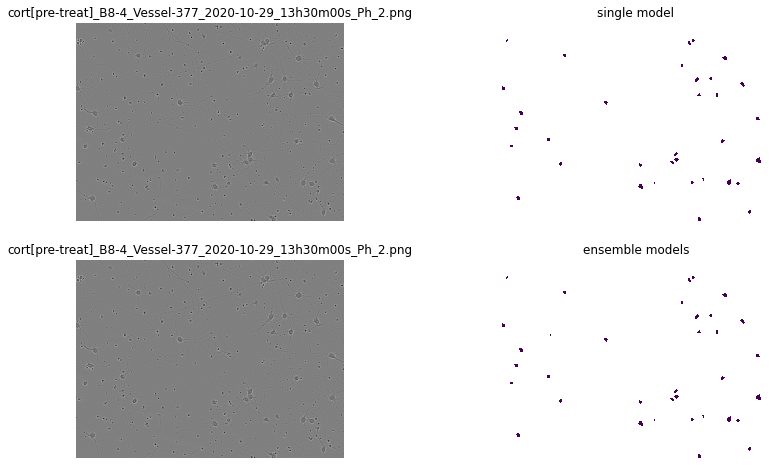

In [ ]:
_, axs = plt.subplots(2, 2, figsize=(14, 8))
axs[0][0].imshow(cv2.imread(f'{SUBM_PATH}/{test_names[ID_TEST]}'))
axs[0][0].axis('off')
axs[0][0].set_title(test_names[ID_TEST])
for en_mask in encoded_masks_single:
    dec_mask = rle_decode(en_mask)
    axs[0][1].imshow(np.ma.masked_where(dec_mask == 0, dec_mask))
    axs[0][1].axis('off')
    axs[0][1].set_title('single model')
axs[1][0].imshow(cv2.imread(f'{SUBM_PATH}/{test_names[ID_TEST]}'))
axs[1][0].axis('off')
axs[1][0].set_title(test_names[ID_TEST])
for en_mask in encoded_masks:
    dec_mask = rle_decode(en_mask)
    axs[1][1].imshow(np.ma.masked_where(dec_mask == 0, dec_mask))
    axs[1][1].axis('off')
    axs[1][1].set_title('ensemble models')
plt.show()


In [ ]:
subm_ids, subm_masks, cell_types = [], [], []
for test_name in tqdm(test_names):
    if SINGLE_MODE:
        encoded_masks = pred_masks(
            test_name, 
            path=SUBM_PATH, 
            model=MODELS[0],
            ths=THSS[0],
            min_pixels=MIN_PIXELS
        )
    else:
        classes, scores, bboxes, masks = ensemble_preds(
            file_name=test_name, 
            path=SUBM_PATH, 
            models=MODELS, 
            ths=THSS
        )
        if NMS:
            classes, scores, masks = nms_predictions(
                classes, 
                scores, 
                bboxes, 
                masks, 
                iou_th=IOU_TH
            )
        encoded_masks = ensemble_pred_masks(
            masks, 
            classes, 
            min_pixels=MIN_PIXELS
        )
    for enc_mask in encoded_masks:
        subm_ids.append(test_name[:test_name.find('.')])
        cell_type = test_name[:1]
        if cell_type=='a': cell_types.append('astro')
        elif cell_type=='s': cell_types.append('shsy5y')
        else: cell_types.append('cort')
        subm_masks.append(enc_mask)

  0%|          | 0/1972 [00:00<?, ?it/s]

In [ ]:
pd.DataFrame({
    'id': subm_ids, 
    'annotation': subm_masks,
    'width': 704,
    'height': 520,
    'cell_type': cell_types,
}).to_csv('pseudo_labels_fold4_ensemble.csv', index=False)
pd.read_csv('pseudo_labels_fold4_ensemble.csv')

,id,annotation,width,height,cell_type
0,cort[pre-treat]_B8-4_Vessel-377_2020-10-29_13h...,141775 5 142476 9 143179 11 143883 12 144586 1...,704,520,cort
1,cort[pre-treat]_B8-4_Vessel-377_2020-10-29_13h...,247074 6 247777 8 248479 11 249182 12 249884 1...,704,520,cort
2,cort[pre-treat]_B8-4_Vessel-377_2020-10-29_13h...,98403 4 99106 7 99809 9 100512 10 101215 12 10...,704,520,cort
3,cort[pre-treat]_B8-4_Vessel-377_2020-10-29_13h...,253181 4 253882 10 254585 12 255289 13 255993 ...,704,520,cort
4,cort[pre-treat]_B8-4_Vessel-377_2020-10-29_13h...,317546 4 318248 8 318951 10 319653 13 320356 1...,704,520,cort
...,...,...,...,...,...
209805,astro[hippo]_E3-1_Vessel-361_2020-09-15_13h00m...,280406 4 281109 5 281816 2 282503 1 282520 2 2...,704,520,astro
209806,astro[hippo]_E3-1_Vessel-361_2020-09-15_13h00m...,327665 4 327672 1 328369 5 328376 2 329072 12 ...,704,520,astro
209807,astro[hippo]_E3-1_Vessel-361_2020-09-15_13h00m...,192084 12 192779 23 193482 25 194182 29 194884...,704,520,astro
209808,astro[hippo]_E3-1_Vessel-361_2020-09-15_13h00m...,158195 1 158899 1 159603 2 160307 2 161011 2 1...,704,520,astro


In [ ]:
len(subm_ids)

209810

convert to json for feeding into detectron2

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from tqdm.notebook import tqdm
from datetime import datetime
import json,itertools
from typing import Optional
from sklearn.model_selection import StratifiedKFold
from joblib import Parallel, delayed


In [ ]:
workers=8

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

# From https://newbedev.com/encode-numpy-array-using-uncompressed-rle-for-coco-dataset
def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(itertools.groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    return rle

def annotate(idx, row, cat_ids):
    mk = rle_decode(row.annotation, (row.height, row.width))
    ys, xs = np.where(mk)
    x1, x2 = min(xs), max(xs)
    y1, y2 = min(ys), max(ys)
    enc =binary_mask_to_rle(mk)
    seg = {
        'segmentation':enc, 
        'bbox': [int(x1), int(y1), int(x2-x1+1), int(y2-y1+1)],
        'area': int(np.sum(mk)),
        'image_id':row.id, 
        'category_id':cat_ids[row.cell_type], 
        'iscrowd':0, 
        'id':idx
    }
    return seg


def coco_structure(train_df):
    #cat_ids = {name:id+1 for id, name in enumerate(train_df.cell_type.unique())}   
    cat_ids={'shsy5y':1,'astro':2,'cort':3} 
    cats =[{'name':name, 'id':id} for name,id in cat_ids.items()]
    images = [{'id':id, 'width':row.width, 'height':row.height, 'file_name':f'train/{id}.png'} for id,row in train_df.groupby('id').agg('first').iterrows()]
    #annotations=[]
    annotations = Parallel(n_jobs=workers)(delayed(annotate)(idx, row, cat_ids) for idx, row in tqdm(train_df.iterrows(), total = len(train_df)))
    return {'categories':cats, 'images':images,'annotations':annotations}

In [ ]:
pseudo_df = pd.read_csv('pseudo_labels_fold4_ensemble.csv')
pseudo_json = coco_structure(pseudo_df)

with open(f'pseudo_labels_fold4_ensemble.json', 'w', encoding='utf-8') as f:
    json.dump(pseudo_json, f, ensure_ascii=True, indent=4)

  0%|          | 0/209810 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
!cp pseudo_labels_f4_maskX101.json /content/drive/MyDrive/Kaggle/sartorius-cell/

In [ ]:
'''import json
f=open('/content/drive/MyDrive/Kaggle/sartorius-cell/pseudo_labels2_f4.json')
data=json.load(f)

data['categories']'''

verify whether json file is correct

In [ ]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

In [ ]:
#download from kaggle using API command 
#i shared pseudo-labels dataset with you 
# but the json file created in this can't be feeded into detectron2 for some reason

!mkdir /root/.kaggle
!cp /content/drive/MyDrive/kaggle.json /root/.kaggle

#!kaggle datasets download -d ferlockx/pseudo-labels

In [ ]:
dataDir=Path('/content/')
annFile = Path('/content/pseudo_labels2_f4.json')
coco = COCO(annFile)
imgIds = coco.getImgIds()

In [ ]:
imgs = coco.loadImgs(imgIds[-3:])
_,axs = plt.subplots(len(imgs),2,figsize=(40,15 * len(imgs)))
for img, ax in zip(imgs, axs):
    I = Image.open(dataDir/img['file_name'])
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco.showAnns(anns)

# Pseudo Labels Training

In [ ]:
dataDir=Path('/content/')

In [ ]:
!unzip /content/drive/MyDrive/Kaggle/sartorius-cell/sartorius-cell-instance-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d00h00m_4.tif  
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d04h00m_1.tif  
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d04h00m_2.tif  
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d04h00m_3.tif  
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d04h00m_4.tif  
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d08h00m_1.tif  
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d08h00m_2.tif  
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A11_2_02d08h00m_3.tif  
  inflating: LIVECell_dataset_2021/images/livecell_train_val_images/Huh7/Huh7_Phase_A

In [ ]:
!mv /content/train_semi_supervised/* train

import pandas as pd
import numpy as np
import pandas as pd 
from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm # progress bar
from datetime import datetime
import time
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import os, json, cv2, random
import skimage.io as io
import copy
from pathlib import Path
from typing import Optional



from tqdm import tqdm
import itertools

import torch
import albumentations as A
#from albumentations.pytorch.transforms import ToTensorV2

from glob import glob
import numba
from numba import jit

import warnings
warnings.filterwarnings('ignore') #Ignore "future" warnings and Data-Frame-Slicing warnings.


# detectron2
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
from detectron2.engine import BestCheckpointer
from detectron2.checkpoint import DetectionCheckpointer

from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

setup_logger()

<Logger detectron2 (DEBUG)>

In [ ]:
Data_Resister_training="sartorius_Cell_train";
Data_Resister_valid="sartorius_Cell_valid";
Data_Resister_pseudo= "sartorius_Cell_pseudo";
from detectron2.data.datasets import register_coco_instances
dataDir=Path('')
dataDir1=Path('')

register_coco_instances(Data_Resister_training,{}, '/content/drive/MyDrive/Kaggle/sartorius-cell/folds_json/coco_cell_train_fold4.json', dataDir)
register_coco_instances(Data_Resister_valid,{},'/content/drive/MyDrive/Kaggle/sartorius-cell/folds_json/coco_cell_valid_fold4.json', dataDir)
register_coco_instances(Data_Resister_pseudo,{}, '/content/drive/MyDrive/Kaggle/sartorius-cell/pseudo_labels_f4.json', dataDir1)

metadata = MetadataCatalog.get(Data_Resister_training)
dataset_train = DatasetCatalog.get(Data_Resister_training)
dataset_valid = DatasetCatalog.get(Data_Resister_valid)


[12/28 06:19:27 d2.data.datasets.coco]: Loading /content/drive/MyDrive/Kaggle/sartorius-cell/folds_json/coco_cell_train_fold4.json takes 1.36 seconds.
[12/28 06:19:27 d2.data.datasets.coco]: Loaded 485 images in COCO format from /content/drive/MyDrive/Kaggle/sartorius-cell/folds_json/coco_cell_train_fold4.json
[12/28 06:19:29 d2.data.datasets.coco]: Loaded 121 images in COCO format from /content/drive/MyDrive/Kaggle/sartorius-cell/folds_json/coco_cell_valid_fold4.json


In [ ]:
dataset_pseudo = DatasetCatalog.get(Data_Resister_pseudo)

fig, ax = plt.subplots(figsize =(18,11))
d=dataset_valid[2] 
img = cv2.imread(d["file_name"])
print(img.shape)
v = Visualizer(img[:, :, ::-1],
                metadata=metadata, 
                scale=1,
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
out = v.draw_dataset_dict(d)
ax.grid(False)
ax.axis('off')
ax.imshow(out.get_image()[:, :, ::-1])

In [ ]:
def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [
            T.RandomBrightness(0.9, 1.1),
            T.RandomContrast(0.9, 1.1),
            T.RandomSaturation(0.9, 1.1),
            T.RandomLighting(0.9),
            T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
            T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
    ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict
class AugTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)

In [ ]:
# Taken from https://www.kaggle.com/theoviel/competition-metric-map-iou
from detectron2.evaluation.evaluator import DatasetEvaluator
import pycocotools.mask as mask_util
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    return np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)

def score(pred, targ):
    pred_masks = pred['instances'].pred_masks.cpu().numpy()
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    enc_targs = list(map(lambda x:x['segmentation'], targ))
    ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, ious)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)

class MAPIOUEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name):
        dataset_dicts = DatasetCatalog.get(dataset_name)
        self.annotations_cache = {item['image_id']:item['annotations'] for item in dataset_dicts}
            
    def reset(self):
        self.scores = []

    def process(self, inputs, outputs):
        for inp, out in zip(inputs, outputs):
            if len(out['instances']) == 0:
                self.scores.append(0)    
            else:
                targ = self.annotations_cache[inp['image_id']]
                self.scores.append(score(out, targ))

    def evaluate(self):
        return {"MaP IoU": np.mean(self.scores)}

class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)

    def build_hooks(self):

        # copy of cfg
        cfg = self.cfg.clone()

        # build the original model hooks
        hooks = super().build_hooks()

        # add the best checkpointer hook
        hooks.insert(-1, BestCheckpointer(cfg.TEST.EVAL_PERIOD, 
                                         DetectionCheckpointer(self.model, cfg.OUTPUT_DIR),
                                         "MaP IoU",
                                         "max",
                                         ))
        return hooks


In [ ]:
cfg = get_cfg()
config_name = "Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_name))
cfg.DATASETS.TRAIN = (Data_Resister_training, Data_Resister_pseudo)
cfg.DATASETS.TEST = (Data_Resister_valid,)

cfg.MODEL.WEIGHTS ="/content/drive/MyDrive/Kaggle/sartorius-cell/livecell_train/cascade_mrcnn/model_best.pth"

#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64  # 64 is slower but more accurate (128 faster but less accurate)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
cfg.SOLVER.IMS_PER_BATCH = 2 #(2 is per defaults)
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

cfg.SOLVER.BASE_LR = 0.0005 #(quite high base learning rate but should drop)
#cfg.SOLVER.MOMENTUM = 0.9
#cfg.SOLVER.WEIGHT_DECAY = 0.0005
#cfg.SOLVER.GAMMA = 0.1

    
cfg.SOLVER.WARMUP_ITERS = 1000 #How many iterations to go from 0 to reach base LR
cfg.SOLVER.MAX_ITER = 100000 #Maximum of iterations 1
cfg.SOLVER.STEPS = (12000, 20000) #At which point to change the LR 0.25,0.5
cfg.TEST.EVAL_PERIOD = 600
cfg.SOLVER.CHECKPOINT_PERIOD=1200*8

cfg.OUTPUT_DIR="/content/drive/MyDrive/Kaggle/sartorius-cell/livecell_train/psuedo_labels/Cascade_w_pseudo_v1"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
#trainer = AugTrainer(cfg) # with  data augmentation  
trainer = Trainer(cfg)  # without data augmentation
trainer.resume_or_load(resume=False)
trainer.train()